# JSC370 - Hello JSC370 - Rough Answers

# Question 0
_Is this an observational study or experiment?  Briefly explain. (see this [reference](http://propensityscoreanalysis.pbworks.com/f/BehStatObserv.study.rosenbaum05.pdf) for a discussion of the two types of studies)_

This is an observational study. Patients treatment was not assigned by randomization.

# Question 1
_Use Python or R to write **functions** that can simulate this study's data set by returning a Pandas data frame/R data frame, with appropriate labels for columns and rows.  It should contain information on patients that received open stone removal and percutaneous removal.  In particular the data set should contain the type of procedure, the outcome of the procedure, and the size of the kidney stone._

The 2x2 table of procedure vs. success for <2cm is: 
        

 Proc  |   success |    fail  | Total
-------|--------|-----------|--------
Open   |     81 | 6        | 87
Perc   |  234    | 36        | 270
Total  | 315    |   42      | 357

The 2x2 table of procedure vs. success for >=2cm is: 
        

 Proc  |   success |    fail  | Total
-------|--------|-----------|--------
Open   |     192 | 71        | 263
Perc   | 55    | 25        | 80
Total  | 247    |   96      | 343




In [1]:
import numpy as np
import pandas as pd

def gendata(a11, a12, a21, a22, labels):
    """
    Generate data based on
              col1   col2
    ----------------------
    row1      a11    a12
    row2      a21    a22
    """
    row1 = np.repeat(labels['row_lab_1'], a11 + a12)
    col1 = np.concatenate((
        np.repeat(labels['col_lab_1'], a11),
        np.repeat(labels['col_lab_2'], a12)
    ))
    row2 = np.repeat(labels['row_lab_2'], a21 + a22)
    col2 = np.concatenate((
        np.repeat(labels['col_lab_1'], a21),
        np.repeat(labels['col_lab_2'], a22)
    ))
    row = np.concatenate((row1, row2))
    col = np.concatenate((col1, col2))
    
    size = np.repeat(labels['size'], np.sum((a11, a12, a21, a22)))
    
    data = {
        labels['row_name']: row,
        labels['col_name']: col,
        labels['size_name']: size
    }
    return(pd.DataFrame(data))

In [2]:
# create labels
label_dict = {
    'row_name': 'proc',
    'row_lab_1': 'open',
    'row_lab_2': 'perc',
    'col_name': 'result',
    'col_lab_1': 'success',
    'col_lab_2': 'failure',
    'size_name': 'size',
    'size': 'le2'
}
df_le2 = gendata(81, 6, 234, 36, label_dict)
label_dict.update({'size': 'ge2'})
df_ge2 = gendata(192, 71, 55, 25, label_dict)
df_all = pd.concat([df_le2, df_ge2])
# set as category data types and order categories
# this makes the odd ratio calculations easier to read
df_all = df_all.astype('category')
df_all['proc'] = df_all['proc'].cat.reorder_categories(
    ['perc', 'open'])
df_all['result'] = df_all['result'].cat.reorder_categories(
    ['failure', 'success']
)

# Question 2

_Calculate two-way contingency tables of success versus procedure:_

+ _among all patients;_
+ _patients with a stone size $\le 2cm$; and_
+ _patients with a stone size $> 2cm$._

_What do you observe?_

In [3]:
tab_all = pd.crosstab(
    df_all['proc'], df_all['result'],
    colnames=['Result'],
    rownames=['Procedure'],
    margins = True
)
# get proportion of success
tab_all['prop_success'] = np.round(
    tab_all['success']/tab_all['All'], 2
)
tab_le2 = pd.crosstab(
    df_le2['proc'], df_le2['result'],
    colnames=['Result'],
    rownames=['Procedure'],
    margins = True
)
# get proportion of success
tab_le2['prop_success'] = np.round(
    tab_le2['success']/tab_le2['All'], 2
)
tab_ge2 = pd.crosstab(
    df_ge2['proc'], df_ge2['result'],
    colnames=['Result'],
    rownames=['Procedure'],
    margins = True
)
# get proportion of success
tab_ge2['prop_success'] = np.round(
    tab_ge2['success']/tab_ge2['All'], 2
)
print('All patients')
display(tab_all)
print('<2cm Group')
display(tab_le2)
print('>=2cm Group')
display(tab_ge2)

All patients


Result,failure,success,All,prop_success
Procedure,,,,
perc,61,289,350,0.83
open,77,273,350,0.78
All,138,562,700,0.80


<2cm Group


Result,failure,success,All,prop_success
Procedure,,,,
open,6,81,87,0.93
perc,36,234,270,0.87
All,42,315,357,0.88


>=2cm Group


Result,failure,success,All,prop_success
Procedure,,,,
open,71,192,263,0.73
perc,25,55,80,0.69
All,96,247,343,0.72


The proportion of success is higher in the open group within each subgroup, yet when the data is aggregated the proportion of success is higher in the perc group.

# Question 3

_Briefly explain why kidney stone size is a confounding variable._

Kidney stone size is most likely a common cause of procedure and outcome.  Therefore, it is a confounding variable. This is why we see this behaviour.

# Question 4

_Fit two logistic regression models to predict outcome: (A) with only procedure as a covariate/feature; and (B) with procedure and size as covariates/features.  Which model gives a more accurate estimate of the odds ratio of success in open versus percutaneous?  Briefly explain._

In [4]:
# randomly split train vs test
# generate len(df_all) Unif[0,1]
np.random.seed(30)
train_i = np.random.rand(len(df_all)) < .75
df_train = df_all[train_i]
df_test = df_all[~train_i]

In [5]:
# load rpy2.ipython to use r in jupyter notebook
%load_ext rpy2.ipython

In [6]:
# import data frames to R environment
%R -i df_train 
%R -i df_test
%R -i df_all

In [7]:
%%R
mod1 <- glm(as.factor(result) ~ 
            as.factor(proc), family = "binomial", 
            data = df_train)
mod2 <- glm(as.factor(result) ~ as.factor(proc) 
            + as.factor(size), family = "binomial", 
            data = df_train)

### Model 1

$$log\left(\frac{p_\rm{success}}{1-p_\rm{success}}\right) = \beta_0 + \beta_1X_\rm{procedure}$$

In [8]:
%%R 
print(summary(mod1))


Call:
glm(formula = as.factor(result) ~ as.factor(proc), family = "binomial", 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9034   0.5974   0.5974   0.6883   0.6883  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)           1.6330     0.1687   9.680   <2e-16 ***
as.factor(proc)open  -0.3135     0.2243  -1.398    0.162    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 514.19  on 531  degrees of freedom
Residual deviance: 512.22  on 530  degrees of freedom
AIC: 516.22

Number of Fisher Scoring iterations: 4



### Model 2

$$log\left(\frac{p_\rm{success}}{1-p_\rm{success}}\right) = \beta_0 + \beta_1X_\rm{procedure} + \beta_2X_\rm{size}$$

In [9]:
%%R
print(summary(mod2))


Call:
glm(formula = as.factor(result) ~ as.factor(proc) + as.factor(size), 
    family = "binomial", data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2897   0.3886   0.4966   0.7680   0.9526  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.5549     0.2603   2.132   0.0330 *  
as.factor(proc)open   0.5150     0.2823   1.824   0.0681 .  
as.factor(size)le2    1.4759     0.2953   4.997 5.81e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 514.19  on 531  degrees of freedom
Residual deviance: 484.89  on 529  degrees of freedom
AIC: 490.89

Number of Fisher Scoring iterations: 4



### Odd ratios of success in open vs. percutaneous

In [10]:
%%R
ors = as.data.frame(cbind(
    c(exp(coef(mod1)[2]), coef(mod1)[2]),
    c(exp(coef(mod2)[2]), coef(mod2)[2])
)) 
colnames(ors) <- c('Model 1', 'Model 2')
rownames(ors) <- c('Odd ratio', 'Log odd ratio')

In [11]:
%R round(ors, 3)

,Model 1,Model 2
Odd ratio,0.731,1.674
Log odd ratio,-0.314,0.515


### Python version for reference (only model 2)

In [12]:
import statsmodels.discrete.discrete_model as sm
import statsmodels.tools as stool

# sm.Logit expects numeric arrays
df_py = df_all.apply(lambda col: col.cat.codes)
df_py['intercept'] = 1 # needs to add the intercept term manually
df_py_train = df_py[train_i]
# specify and fit models
mdl_2 = sm.Logit(
    df_py_train['result'], 
    df_py_train[['intercept', 'proc', 'size']])
fitted_2 = mdl_2.fit()

# print results 
print("\n##### Model 2 with `proc` and `size`. ######")
display(fitted_2.summary())
# calculate odd ratios
# fitted_1.params
lor2 = fitted_2.params[1]
print('Model 2 odd ratio of success for open vs. percutaneous')
print('Odd ratio: {:.3f}'.format(np.exp(lor2)))
print('Log odd ratio: {:.3f}'.format(lor2))

Optimization terminated successfully.
         Current function value: 0.455724
         Iterations 6

##### Model 2 with `proc` and `size`. ######


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 result   No. Observations:                  532
Model:                          Logit   Df Residuals:                      529
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Jan 2020   Pseudo R-squ.:                 0.05699
Time:                        23:18:42   Log-Likelihood:                -242.44
converged:                       True   LL-Null:                       -257.10
Covariance Type:            nonrobust   LLR p-value:                 4.330e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5549      0.260      2.132      0.033       0.045       1.065
proc           0.5150      0.282      1.824      0.068      -0.038       1.068
size           1.4759      0.295      4.997      0.000       0.897       2.055
==============================================================================
"""

Model 2 odd ratio of success for open vs. percutaneous
Odd ratio: 1.674
Log odd ratio: 0.515


# Question 5


_Construct an ROC curve for the model in 4. What is the accuracy of the model(s) in 4.?  What do you observe?_

### Model 1

R[write to console]: Setting levels: control = failure, case = success

R[write to console]: Setting direction: controls < cases



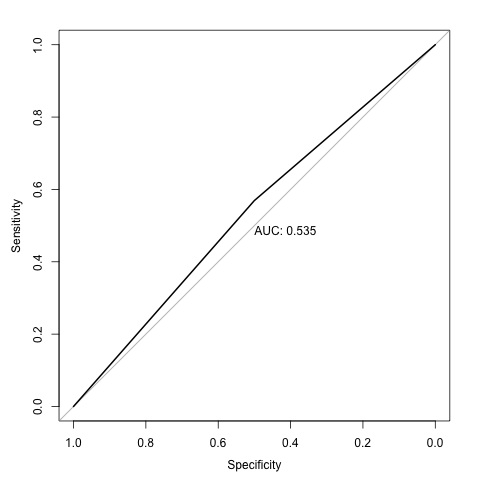

In [19]:
%%R
options(warn=-1)
# plot ROC usingn pROC library
library(pROC)
pred1 <- predict(mod1, newdata = df_test, type = "response")
plot.roc(df_test$result, pred1, print.auc = TRUE);

### Model 2

R[write to console]: Setting levels: control = failure, case = success

R[write to console]: Setting direction: controls < cases



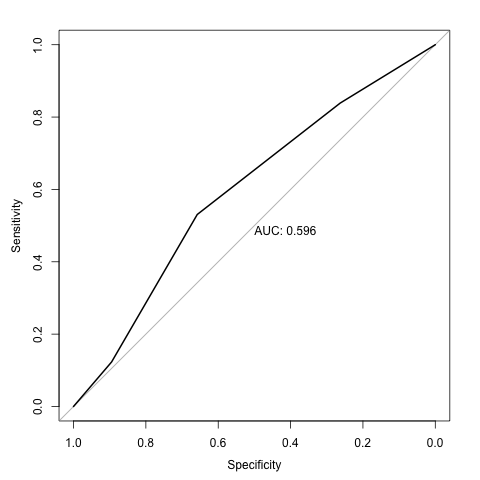

In [20]:
%%R
pred2 <- predict(mod2, newdata = df_test, type = "response")
plot.roc(df_test$result, pred2, print.auc = TRUE)

# Question 6

_The ["Objective of stratification is to fix the level of the confounders and produce groups within which the confounder does not vary. Then evaluate the exposure-outcome association within each stratum of the confounder. So within each stratum, the confounder cannot confound because it does not vary across the exposure-outcome."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/) Calculate the common/pooled odds-ratio (sometimes called the Mantel Haenszel odds ratio) of success in open versus percutaneous.  Does a stratified analysis seem appropriate in this case?  Compare the stratified analysis to the models in 4?_

In [15]:
import statsmodels.api as sm

piv1 = pd.pivot_table(
    df_train, index = ['size', 'proc'],
    columns = ['result'],
    aggfunc = len)
mat = piv1.values
tables = np.concatenate((
    mat[0], mat[1])), np.concatenate((mat[2], mat[3])
                                    )
t1 = np.reshape(tables[0], (2,2))
t2 = np.reshape(tables[1], (2,2))
tables = [t1, t2]
st = sm.stats.StratifiedTable(tables)
st.summary()

,Estimate,LCB,UCB
Pooled odds,1.748,0.980,3.118
Pooled log odds,0.559,-0.020,1.137
Pooled risk ratio,1.536,,
,,,
,Statistic,P-value,
Test of OR=1,3.341,0.068,
Test constant OR,3.216,0.073,
,,,
Number of tables,2,,
Min n,257,,


The results of the Mantel-Haenszel _(1.748 in natural scale and 0.559 in log scale)_ and the logistic regression model `mod2` _(1.674 in natural scale and 0.515 in log scale)_ produce similar estimates of the odds ratio for procedure.  Open compared to percutaneous may lead to better surgical outcomes, although further study would be required.

## Checking OR calculations

Double check pooled OR calculation.  The estimator for pooled odds ratio is:

$$\hat OR_{MH} = \frac{\sum_{i=1}^k a_id_i/n_i}{\sum_{i=1}^k b_ic_i/n_i},$$

where $k=1,2$ is the number of tables, $n_i = a_i+b_i+c_i+d_i$,

| proc | success | fail |
|------|------|---------|
| open | $a_i$  | $b_i$     |
| perc  | $c_i$  | $d_i$     |

$i=1,2$ corresponds to $\leq 2cm$ and $>2cm$.

In [16]:
def get_mh_or(df, by='size', res='result', treat='proc'):
    """
    Calculate Mantel-Haenszel odd ratio
    for the renal calculi data.
    """
    # divide into subsets by 'by'
    subs = [df[df[by]==b] for b in df[by].unique()]
    # create contingency tables
    conts = [pd.crosstab(
        sub[treat], sub[res], 
        margins = True
    ) for sub in subs]
    # calculate a_i*d_i/n_i for each table
    numers = [
        c.loc['open','success']*c.loc['perc','failure'] / 
        c.loc['All','All']
        for c in conts
    ]
    # calculate b_i*c_i/n_i for each table
    denoms = [
        c.loc['open','failure']*c.loc['perc','success'] / 
        c.loc['All','All']
        for c in conts
    ]
    mh = np.sum(numers)/np.sum(denoms)
    return mh
    
mh_or = get_mh_or(df_train)
log_mh = np.log(mh_or)
print('Pooled odd ratio: {:.4f}'.format(mh_or))
print('Pooled log odd ratio: {:.4f}'.format(log_mh))

Pooled odd ratio: 1.7483
Pooled log odd ratio: 0.5586


The calculated values match the outputs from the `statsmodels` package.

# Question 7

_Is the odds ratio of success similar to the [relative risk](https://www.ncbi.nlm.nih.gov/books/NBK430824/) of success in this case (i.e., open vs. percutaneous)? Briefly, explain why it's the same or different?_

### Relative risk of success for $>=2\rm{cm}$ group

$$\frac{
P\left(\rm{succes}\vert\rm{proc}=\rm{open}\right)}{
P\left(\rm{success}\vert\rm{proc}=\rm{perc}\right)}$$

### Relative risk of success for $<2\rm{cm}$ group

$$\frac{
P\left(\rm{succes}\vert\rm{proc}=\rm{open}\right)}{
P\left(\rm{success}\vert\rm{proc}=\rm{perc}\right)}$$

In [17]:
# define functions
def get_rr(df):
    """
    Calculate relative risks
    for the renal calculi data.
    """
    tab = pd.crosstab(
        df['proc'], df['result'], 
        margins = True)
    rr = (
        tab.loc['open','success']*tab.loc['perc', 'All'])/(
        tab.loc['open', 'All']*tab.loc['perc', 'success'])
    return rr

def get_or(df):
    """
    Calculate odd ratios
    for the renal calculi data.
    """
    tab = pd.crosstab(
        df['proc'], df['result'], 
        margins = True)
    oddr = (
        tab.loc['open','success']*tab.loc['perc', 'failure'])/(
        tab.loc['open', 'failure']*tab.loc['perc', 'success'])
    return oddr

# calculate and save as a data frame
ratios = np.stack([
    np.array((get_rr(df_le2), get_rr(df_ge2), get_rr(df_all))),
    np.array((get_or(df_le2), get_or(df_ge2), get_or(df_all)))
], axis=1)
rr_or = pd.DataFrame(
    ratios, 
    columns=['Relative Risks', 'Odd Ratios'],
    index=['<2cm Group', '>=2cm Group', 'All']
)

### Comparison

In [18]:
np.round(rr_or, 3)

,Relative Risks,Odd Ratios
<2cm Group,1.074,2.077
>=2cm Group,1.062,1.229
All,0.945,0.748


The values are consistent in their directions around 1. That is, both values 
The values are different since the denominators for risks and odds are different. 

# Question 8

_Which procedure (open or percutaneous) is more effective?  Explain your reasoning._

The analysis shows that the open procedure leads to more successful surgical outcomes when the size of the stone is $<2cm$ and $>2cm$.  The appropriate analysis is to either adjust for size using logistic regression or a stratified analysis using the MH pooled odds ratio.   